In [2]:
import matplotlib.pyplot as plt 
import pandas as pd

In [58]:
def plot_results(df, model_name):
    """
    Given a dataframe with results of the model, plot accuracy and loss of epochs 
    
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(model_name)
    df.plot(y=['train acc', 'val acc'], ax=axes[0])
    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')
    best_train_acc = df['train acc'].max()
    best_train_acc_epoch = df['train acc'].idxmax(0)
    best_test_acc = df['val acc'].max()
    best_test_acc_epoch = df['val acc'].idxmax(0)
    best_train_loss = df['train loss'].min()
    best_train_loss_epoch = df['train loss'].idxmin(0)
    best_test_loss = df['val loss'].min()
    best_test_loss_epoch = df['val loss'].idxmin(0)
    axes[0].set_xlabel('Best train acc: {:.2f} on epoch {}\nBest test acc: {:.2f} on epoch {}'
                       .format(best_train_acc, best_train_acc_epoch, best_test_acc, best_test_acc_epoch))
    axes[1].set_xlabel('Best train loss: {:.2f} on epoch {}\nBest test loss: {:.2f} on epoch {}'
                   .format(best_train_loss, best_train_loss_epoch, best_test_loss, best_test_loss_epoch))
    df.plot(y=['train loss', 'val loss'], ax=axes[1])

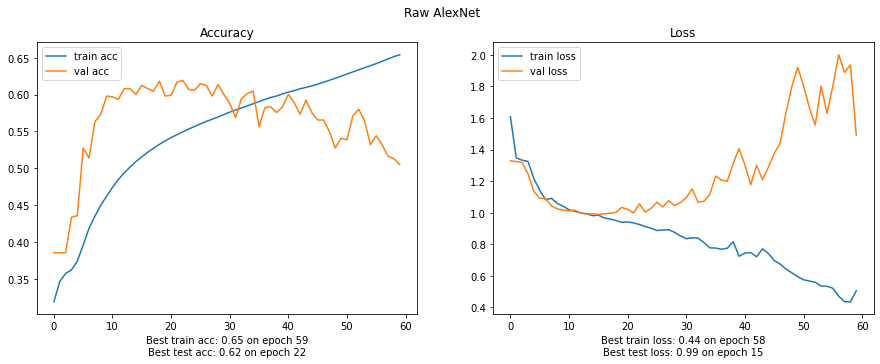

In [59]:
df = pd.read_csv('first_result.csv', delimiter=';')
df = df.head(60)
plot_results(df, 'Raw AlexNet')